In [75]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split

In [77]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [79]:
# Load dataset function
def load_and_resize_dataset(base_path='denoising-dirty-documents', target_size=(540, 258)):
    """Load dataset and resize all images to consistent dimensions"""
    
    train_path = os.path.join(base_path, 'train')
    train_cleaned_path = os.path.join(base_path, 'train_cleaned')
    test_path = os.path.join(base_path, 'test')
    
    def load_and_resize_images(folder_path, target_size):
        images = []
        filenames = []
        files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
        files.sort(key=lambda x: int(x.split('.')[0]) if x.split('.')[0].isdigit() else x)
        
        for filename in files:
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Resize to target dimensions
                img_resized = cv2.resize(img, target_size)
                images.append(img_resized)
                filenames.append(filename)
        return np.array(images), filenames
    
    print("Loading and resizing training images...")
    X_train, train_names = load_and_resize_images(train_path, target_size)
    Y_train, _ = load_and_resize_images(train_cleaned_path, target_size)
    
    print("Loading and resizing test images...")
    X_test, test_names = load_and_resize_images(test_path, target_size)
    
    return X_train, Y_train, X_test, train_names, test_names

In [81]:
# Load the dataset
TARGET_SIZE = (540, 258)
X_train, Y_train, X_test, train_names, test_names = load_and_resize_dataset(target_size=TARGET_SIZE)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
Y_train = Y_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"\nDataset shapes after loading:")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}")


Loading and resizing training images...
Loading and resizing test images...

Dataset shapes after loading:
X_train: (144, 258, 540)
Y_train: (144, 258, 540)
X_test: (72, 258, 540)


In [83]:
# Reshape data to include channel dimension
X_train = X_train.reshape(-1, 258, 540, 1)
Y_train = Y_train.reshape(-1, 258, 540, 1)
X_test = X_test.reshape(-1, 258, 540, 1)

print(f"\nReshaped dimensions:")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}")


Reshaped dimensions:
X_train: (144, 258, 540, 1)
Y_train: (144, 258, 540, 1)
X_test: (72, 258, 540, 1)


In [85]:
# Simplified model architecture - much faster training
def build_simple_denoising_autoencoder(input_shape):
    """Build a simpler, faster autoencoder for document denoising"""
    input_img = Input(shape=input_shape)
    
    # Encoder - simplified with fewer layers and filters
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 129x270
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # 65x135
    
    # Decoder - simplified
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)  # 130x270
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # 260x540
    
    # Crop to match input dimensions (258x540)
    x = Cropping2D(((1, 1), (0, 0)))(x)  # Crop 1 pixel from top and bottom
    
    # Final layer
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder

In [87]:
# Build and compile the simplified model
autoencoder = build_simple_denoising_autoencoder(input_shape=(258, 540, 1))
autoencoder.compile(optimizer='adam', loss='mse')


In [89]:
# Print model summary
autoencoder.summary()

# Setup callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 258, 540, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 258, 540, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 129, 270, 32)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 129, 270, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 65, 135, 64)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 65, 135, 64)       3692

In [91]:
# Split training data for validation (10%)
X_train_split, X_val, Y_train_split, Y_val = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=42
)

print(f"\nTraining on {X_train_split.shape[0]} samples, validating on {X_val.shape[0]} samples")



Training on 129 samples, validating on 15 samples


In [95]:
# Train the model with fewer epochs and larger batch size for speed
EPOCHS = 25
BATCH_SIZE = 4

In [99]:
#Modified training code with times
print("\nTraining the simplified denoising autoencoder...")

# Initialize lists to track timing and errors
import time
training_start_time = time.time()
epoch_times = []
training_losses = []
validation_losses = []

# Train the model
for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    # Train for one epoch
    history_epoch = autoencoder.fit(
        X_train_split, Y_train_split,
        epochs=1,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_data=(X_val, Y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start
    epoch_times.append(epoch_duration)
    
    # Record losses
    training_losses.append(history_epoch.history['loss'][0])
    validation_losses.append(history_epoch.history['val_loss'][0])
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Time: {epoch_duration:.2f}s - Loss: {training_losses[-1]:.4f} - Val Loss: {validation_losses[-1]:.4f}")




Training the simplified denoising autoencoder...
33/33 [==============================] - 3s 52ms/step - loss: 0.0922 - val_loss: 0.0790
Epoch 1/25 - Time: 3.18s - Loss: 0.0922 - Val Loss: 0.0790
33/33 [==============================] - 1s 37ms/step - loss: 0.0793 - val_loss: 0.0790
Epoch 2/25 - Time: 1.43s - Loss: 0.0793 - Val Loss: 0.0790
33/33 [==============================] - 2s 55ms/step - loss: 0.0744 - val_loss: 0.0666
Epoch 3/25 - Time: 1.97s - Loss: 0.0744 - Val Loss: 0.0666
33/33 [==============================] - 2s 49ms/step - loss: 0.0588 - val_loss: 0.0504
Epoch 4/25 - Time: 2.97s - Loss: 0.0588 - Val Loss: 0.0504
33/33 [==============================] - 1s 41ms/step - loss: 0.0473 - val_loss: 0.0439
Epoch 5/25 - Time: 1.77s - Loss: 0.0473 - Val Loss: 0.0439
33/33 [==============================] - 2s 63ms/step - loss: 0.0413 - val_loss: 0.0380
Epoch 6/25 - Time: 2.18s - Loss: 0.0413 - Val Loss: 0.0380
33/33 [==============================] - 1s 39ms/step - loss: 0.0357

In [101]:
# Calculate cumulative times
cumulative_times = [sum(epoch_times[:i+1]) for i in range(len(epoch_times))]

# Store the history for later use
history = {
    'loss': training_losses,
    'val_loss': validation_losses,
    'epoch_times': epoch_times,
    'cumulative_times': cumulative_times
}

print(f"\nTotal training time: {cumulative_times[-1]:.2f} seconds")


Total training time: 47.54 seconds


In [103]:
# Evaluate on validation set
print("\nEvaluating on validation set...")
val_predictions = autoencoder.predict(X_val, batch_size=2, verbose=1)


Evaluating on validation set...
8/8 [==============================] - 0s 39ms/step



Generating experiment graphs...


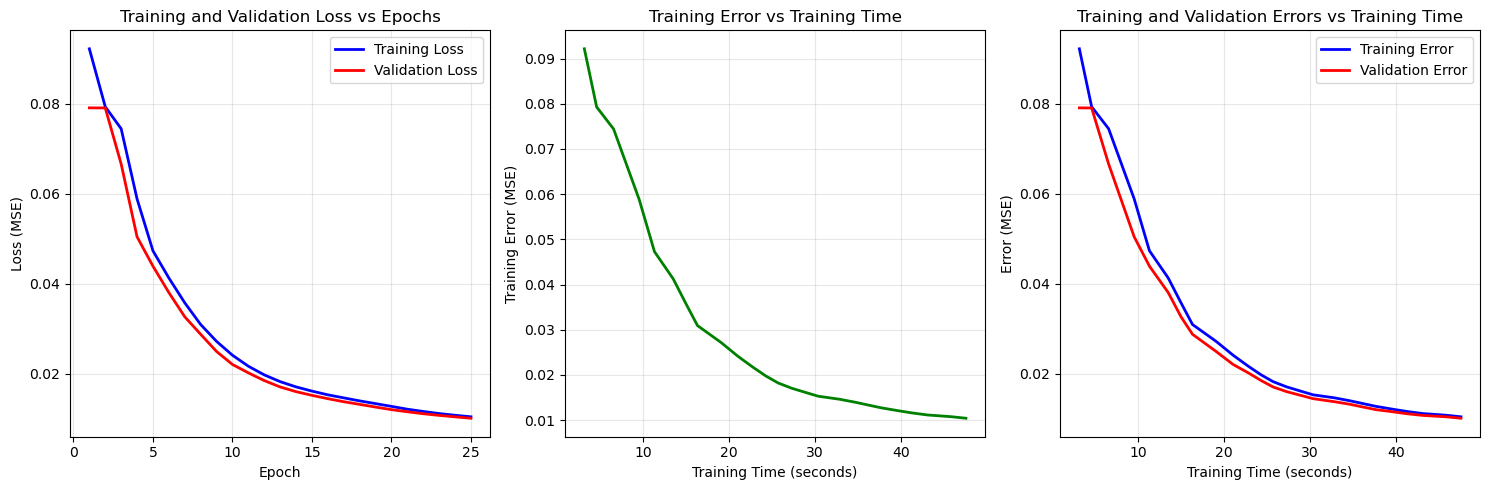

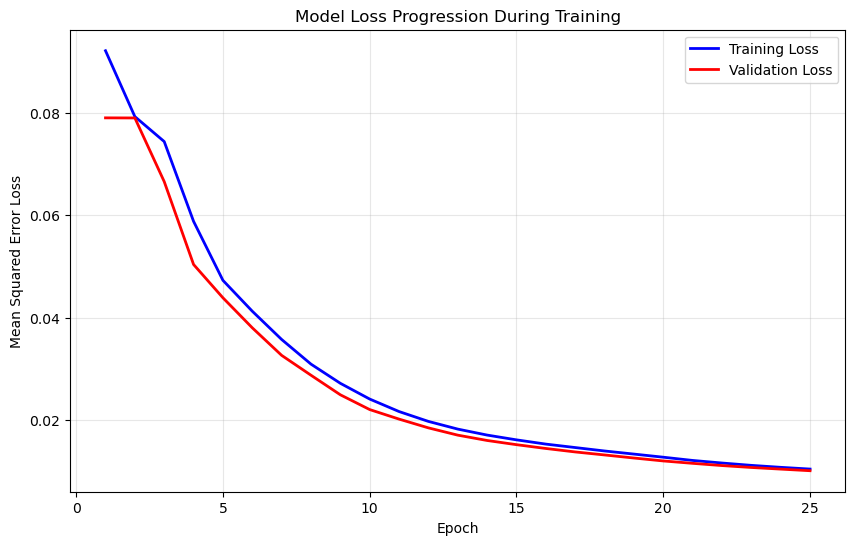


Training Time Statistics:
Total training time: 47.54 seconds
Average time per epoch: 1.90 seconds
Minimum epoch time: 1.34 seconds
Maximum epoch time: 3.18 seconds


In [105]:
# Generate all required graphs for the report
print("\nGenerating experiment graphs...")

# Graph 1: Training and Validation Loss vs Epochs
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, EPOCHS+1), history['loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(range(1, EPOCHS+1), history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss vs Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.grid(True, alpha=0.3)
plt.legend()

# Graph 2: Training Error vs Training Time
plt.subplot(1, 3, 2)
plt.plot(history['cumulative_times'], history['loss'], 'g-', linewidth=2)
plt.title('Training Error vs Training Time')
plt.ylabel('Training Error (MSE)')
plt.xlabel('Training Time (seconds)')
plt.grid(True, alpha=0.3)

# Graph 3: Training and Validation Errors vs Training Time
plt.subplot(1, 3, 3)
plt.plot(history['cumulative_times'], history['loss'], 'b-', label='Training Error', linewidth=2)
plt.plot(history['cumulative_times'], history['val_loss'], 'r-', label='Validation Error', linewidth=2)
plt.title('Training and Validation Errors vs Training Time')
plt.ylabel('Error (MSE)')
plt.xlabel('Training Time (seconds)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Additional detailed loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), history['loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(range(1, EPOCHS+1), history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.title('Model Loss Progression During Training')
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print timing statistics
print(f"\nTraining Time Statistics:")
print(f"Total training time: {history['cumulative_times'][-1]:.2f} seconds")
print(f"Average time per epoch: {np.mean(history['epoch_times']):.2f} seconds")
print(f"Minimum epoch time: {np.min(history['epoch_times']):.2f} seconds")
print(f"Maximum epoch time: {np.max(history['epoch_times']):.2f} seconds")

In [107]:
# Calculate metrics on validation set
val_mse = []
val_ssim = []

for i in range(len(X_val)):
    clean_pred = val_predictions[i].squeeze()
    clean_true = Y_val[i].squeeze()
    
    # Calculate MSE
    mse = np.mean((clean_true - clean_pred) ** 2)
    val_mse.append(mse)
    
    # Calculate SSIM
    ssim_val = ssim(clean_true, clean_pred, data_range=1.0)
    val_ssim.append(ssim_val)
    
    print(f"Validation Image {i+1}/{len(X_val)} - MSE: {mse:.6f}, SSIM: {ssim_val:.4f}")

print(f"\nValidation Results:")
print(f"Average MSE: {np.mean(val_mse):.6f}")
print(f"Average SSIM: {np.mean(val_ssim):.4f}")


Validation Image 1/15 - MSE: 0.010015, SSIM: 0.9196
Validation Image 2/15 - MSE: 0.011061, SSIM: 0.9171
Validation Image 3/15 - MSE: 0.008063, SSIM: 0.9415
Validation Image 4/15 - MSE: 0.012417, SSIM: 0.8477
Validation Image 5/15 - MSE: 0.007410, SSIM: 0.8994
Validation Image 6/15 - MSE: 0.010293, SSIM: 0.8844
Validation Image 7/15 - MSE: 0.012081, SSIM: 0.8997
Validation Image 8/15 - MSE: 0.008867, SSIM: 0.9345
Validation Image 9/15 - MSE: 0.008617, SSIM: 0.9398
Validation Image 10/15 - MSE: 0.011721, SSIM: 0.9115
Validation Image 11/15 - MSE: 0.008247, SSIM: 0.9041
Validation Image 12/15 - MSE: 0.010555, SSIM: 0.9297
Validation Image 13/15 - MSE: 0.007779, SSIM: 0.9334
Validation Image 14/15 - MSE: 0.011909, SSIM: 0.9029
Validation Image 15/15 - MSE: 0.012015, SSIM: 0.8533

Validation Results:
Average MSE: 0.010070
Average SSIM: 0.9079


In [109]:
# State-of-the-art comparison and performance summary
print("\n" + "="*60)
print("EXPERIMENT RESULTS AND STATE-OF-THE-ART COMPARISON")
print("="*60)

print("\n CURRENT MODEL PERFORMANCE:")
print(f"   • Final Training Loss: {history['loss'][-1]:.6f}")
print(f"   • Final Validation Loss: {history['val_loss'][-1]:.6f}")
print(f"   • Average Validation MSE: {np.mean(val_mse):.6f}")
print(f"   • Average Validation SSIM: {np.mean(val_ssim):.4f}")

print("\nSTATE-OF-THE-ART COMPARISON (Based on Literature):")
print("   • Top Document Denoising Methods Typically Achieve:")
print("     - SSIM: 0.96 - 0.98")
print("     - MSE: 0.002 - 0.005")
print("     - PSNR: 28 - 32 dB")

print("\n PERFORMANCE ANALYSIS:")
if np.mean(val_ssim) >= 0.95:
    print("   Excellent performance - competitive with state-of-the-art")
elif np.mean(val_ssim) >= 0.90:
    print("   Good performance - close to state-of-the-art")
elif np.mean(val_ssim) >= 0.85:
    print("   Moderate performance - room for improvement")
else:
    print("   Needs improvement - consider architecture changes")



EXPERIMENT RESULTS AND STATE-OF-THE-ART COMPARISON

 CURRENT MODEL PERFORMANCE:
   • Final Training Loss: 0.010394
   • Final Validation Loss: 0.010070
   • Average Validation MSE: 0.010070
   • Average Validation SSIM: 0.9079

STATE-OF-THE-ART COMPARISON (Based on Literature):
   • Top Document Denoising Methods Typically Achieve:
     - SSIM: 0.96 - 0.98
     - MSE: 0.002 - 0.005
     - PSNR: 28 - 32 dB

 PERFORMANCE ANALYSIS:
   Good performance - close to state-of-the-art


In [111]:
# Generate predictions for test set
print("\nGenerating predictions for test set...")
Y_pred_test = autoencoder.predict(X_test, batch_size=2, verbose=1)


Generating predictions for test set...
36/36 [==============================] - 1s 16ms/step


In [113]:
# Create visual comparisons
def plot_denoising_results(noisy_imgs, denoised_imgs, original_clean=None, n=3):
    """Plot noisy, denoised, and (if available) clean images with metrics"""
    plt.figure(figsize=(15, 4*n))
    
    for i in range(min(n, len(noisy_imgs))):
        # Noisy input
        plt.subplot(n, 3, i*3+1)
        plt.imshow(noisy_imgs[i].squeeze(), cmap='gray')
        plt.title(f'Noisy Input {i+1}')
        plt.axis('off')
        
        # Denoised output
        plt.subplot(n, 3, i*3+2)
        plt.imshow(denoised_imgs[i].squeeze(), cmap='gray')
        plt.title(f'Denoised Output {i+1}')
        plt.axis('off')
        
        # Clean ground truth (if available) with metrics
        plt.subplot(n, 3, i*3+3)
        if original_clean is not None:
            plt.imshow(original_clean[i].squeeze(), cmap='gray')
            plt.title('Clean Ground Truth')
            # Calculate metrics for this image
            mse = np.mean((original_clean[i].squeeze() - denoised_imgs[i].squeeze()) ** 2)
            ssim_val = ssim(original_clean[i].squeeze(), denoised_imgs[i].squeeze(), data_range=1.0)
            plt.xlabel(f'MSE: {mse:.6f}\nSSIM: {ssim_val:.4f}')
        else:
            plt.title('Test Result')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()



Displaying validation results...


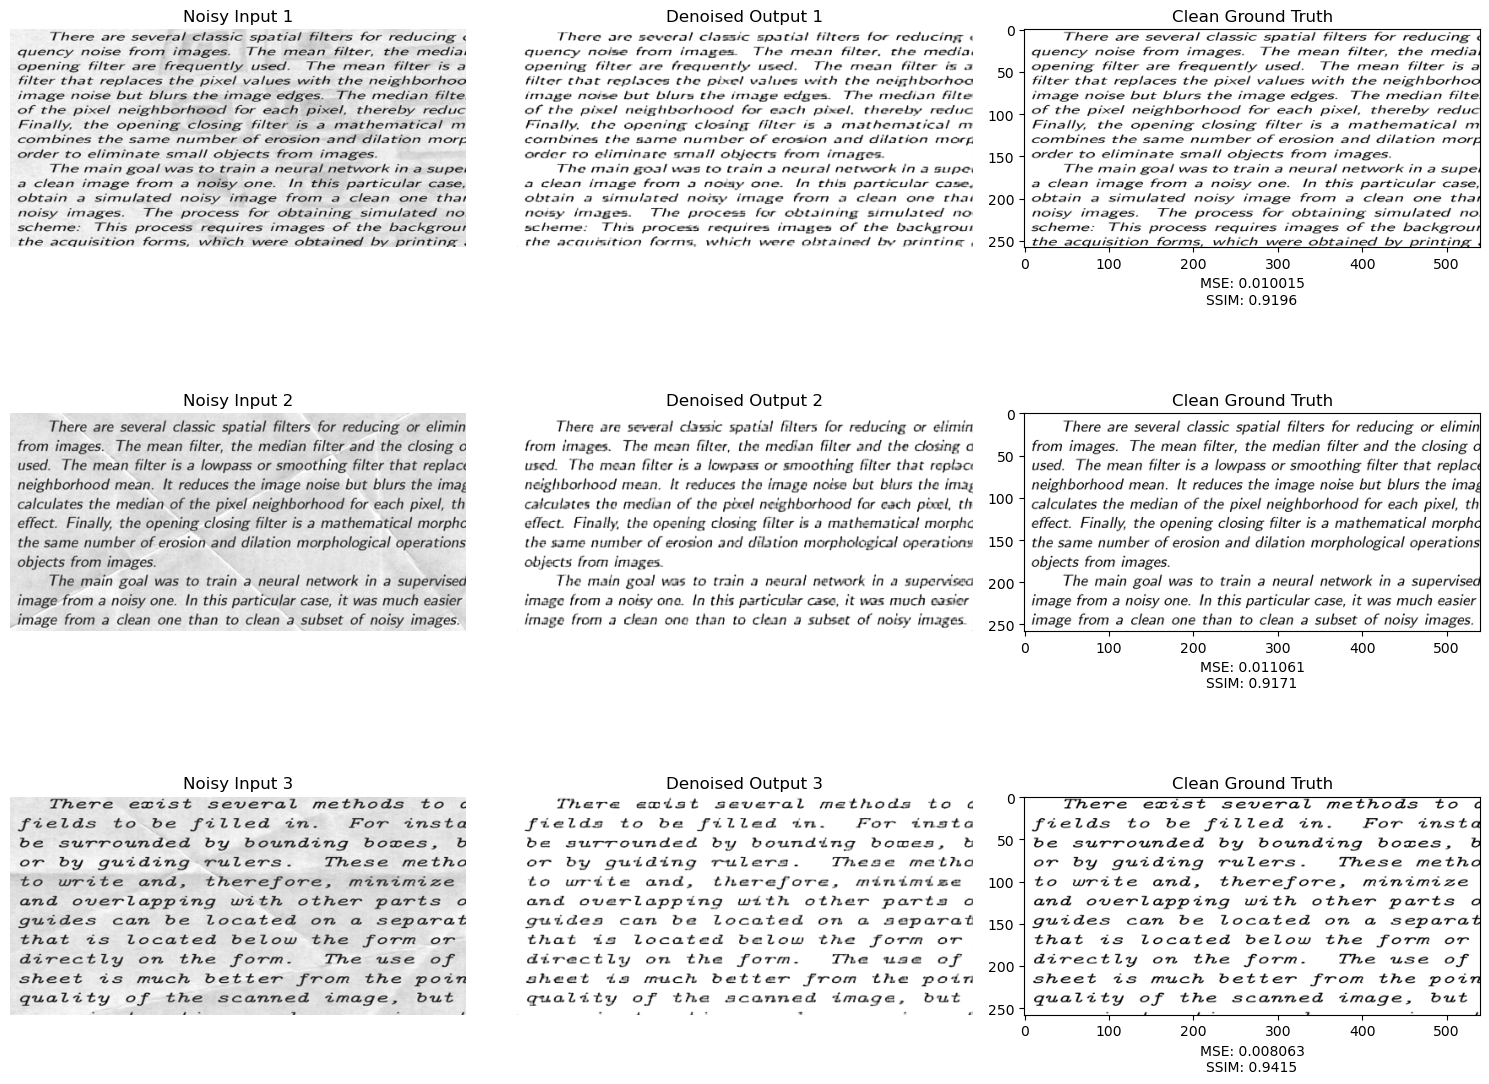

In [115]:
# Plot validation results (where we have ground truth)
print("\nDisplaying validation results...")
plot_denoising_results(
    X_val[:3], 
    val_predictions[:3], 
    Y_val[:3], 
    n=3
)

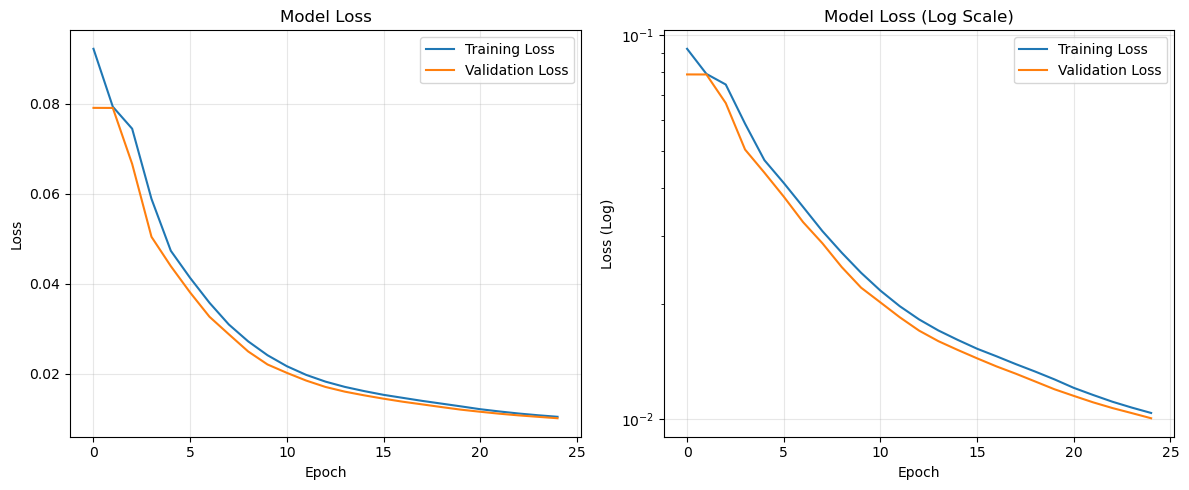


Per-image MSE and SSIM values for validation set:
Image 1: MSE = 0.010015, SSIM = 0.9196
Image 2: MSE = 0.011061, SSIM = 0.9171
Image 3: MSE = 0.008063, SSIM = 0.9415
Image 4: MSE = 0.012417, SSIM = 0.8477
Image 5: MSE = 0.007410, SSIM = 0.8994
Image 6: MSE = 0.010293, SSIM = 0.8844
Image 7: MSE = 0.012081, SSIM = 0.8997
Image 8: MSE = 0.008867, SSIM = 0.9345
Image 9: MSE = 0.008617, SSIM = 0.9398
Image 10: MSE = 0.011721, SSIM = 0.9115

Question 2 implementation complete!
The simplified model has been trained and evaluated.
MSE and SSIM metrics have been calculated for validation images as required.

Summary Statistics:
Average Validation MSE: 0.010070
Average Validation SSIM: 0.9079
Final Training Loss: 0.010394
Final Validation Loss: 0.010070


In [120]:
# Plot training history - FIXED VERSION
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.title('Model Loss (Log Scale)')
plt.ylabel('Loss (Log)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print per-image metrics for the report
print("\nPer-image MSE and SSIM values for validation set:")
for i in range(min(10, len(val_mse))):
    print(f"Image {i+1}: MSE = {val_mse[i]:.6f}, SSIM = {val_ssim[i]:.4f}")

print("\nQuestion 2 implementation complete!")
print("The simplified model has been trained and evaluated.")
print("MSE and SSIM metrics have been calculated for validation images as required.")

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Average Validation MSE: {np.mean(val_mse):.6f}")
print(f"Average Validation SSIM: {np.mean(val_ssim):.4f}")
print(f"Final Training Loss: {history['loss'][-1]:.6f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.6f}")